# Energy A.I. Hackathon 2024 Workflow - Group TV-NYS 

#### Authors: Syed Talha Tirmizi, Oriyomi Raheem, Vivek Singh, Neha Desaraju & Itzhak Estrella
#### Affiliated Schools: Hildebrand Austin Department of Petroleum and Geosystems Engineering & The University of Texas: Department of Computer Science 

#### The University of Texas at Austin, Austin, Texas, USA 
___
### Executive Summary 

This problem involves the use of the difference in the pump pressure of the wells during the drillout of the hydraulically fractured wells, making it challenging to decide on the appropriate fluid system. To address the problem, our team built a data analytics and machine learning workflow that involved evaluating multiple data sources, performing feature engineering (including selection, transformations, and imputation), integrating domain expertise, and selecting, training, and tuning multiple robust machine learning prediction models. Through the project, our team learned the importance of comprehensive data analytics, thoughtful feature engineering, and the importance of collaboration with domain experts to enhance the accuracy of machine learning models in predicting the *average pump difference*. Moving forward, our team recommends the continued refinement and application of the developed machine learning model to support the determination of the optimum fluid type, aiming to prevent fluid loss during well drillout

___
### Workflow Goal

The purpose and goal of this notebook is to bring insights on how machine learning can be help us predict average pump difference with uncertainty. 

___
### Workflow Steps 

1. **Data Analysis** - basic data checking for pattern detection and data visualization for story telling 
2. **Data Cleaning** - data cleaning techniques to improve future model prediction
2. **Feature Selection** - mutual information-based approach by using variable ranking, correlation, and domain knowledge
3. **Machine Learning Model Exploration** - exploring multiple predictive models to predict 'Avg Pump Difference' feature 
    1. **k-NN** 
    2. **Random Forests**
    3. **Gradient Boost**
    4. **XGBoost**
    5. **Ridge & Lasso Regression**
    6. **Linear Regression**
4. **Final Predictive Model - Linear Regression** - best model based on RMSE and Goodness of Fit Test


### Import Packages

In [71]:
# -*- math libraries -*-
import numpy as np                                      # model arrays
import math                                             # math functions
# -*- dataset libraries -*-
import pandas as pd                                     # dataframes
# -*- data visualization libraries -*-
import matplotlib.pyplot as plt                         # building plots
import seaborn as sns                                   # fancy plots
# -*- machine learning libraries -*-
import statsmodels.api as sm                            # linear models
from sklearn.metrics import mean_squared_error          # MSE  
from sklearn.linear_model import Lasso                  # lasso regression
from sklearn.linear_model import Ridge                  # ridge regression
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor      # random forest
from sklearn.neighbors import KNeighborsRegressor       # k-nearest neighbors
from sklearn.ensemble import GradientBoostingRegressor  # gradient boosting
from sklearn.preprocessing import StandardScaler        # standard scaler
from sklearn.model_selection import train_test_split    # train/test split
from sklearn import preprocessing                       # scaling data
from sklearn.impute import KNNImputer                   # imputing missing data
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score     # cross validation

### Load Data

The following workflow applies the .csv file 'HackathonData2024.csv', a synthetic dataset provided by the Energy A.I. Hackathon 2024 organizers. 

In [72]:
pump_df = pd.read_csv("HackathonData2024.csv")         # load the comma delimited data file
copy_pump_df = pump_df.copy()                          # create a copy of the data frame
TARGET = 'Avg Pump Difference'                         # set the target variable as a global variable
print('Shape of the data frame:', pump_df.shape)       # check the shape of the data frame
pump_df.head()                                         # check the structure of the data frame

Shape of the data frame: (348, 41)


,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
0,1,-0.93,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.593758,34,3304.124833,261.7,2719.898438,472.4
1,2,-8.45,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.597059,67,3301.199254,255.9,2934.885325,747.4
2,3,8.70,Arches,11000,Campbell,8470.0,Orange Crush,0,101111,Middle,...,682,4.5,0.0,11,0.516873,34,2774.407080,184.8,1589.948673,596.9
3,4,NaN,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
4,5,19.93,Badlands,2300,Campbell,9295.0,Mountain Dew,1,10001101,Edge,...,277,1.0,1.0,2,0.503327,336,NaN,NaN,NaN,NaN


### Data Analysis
The cell boxes will demonstrate our data analysis workflow and approaches.

Total number of attributes with missing values:  22


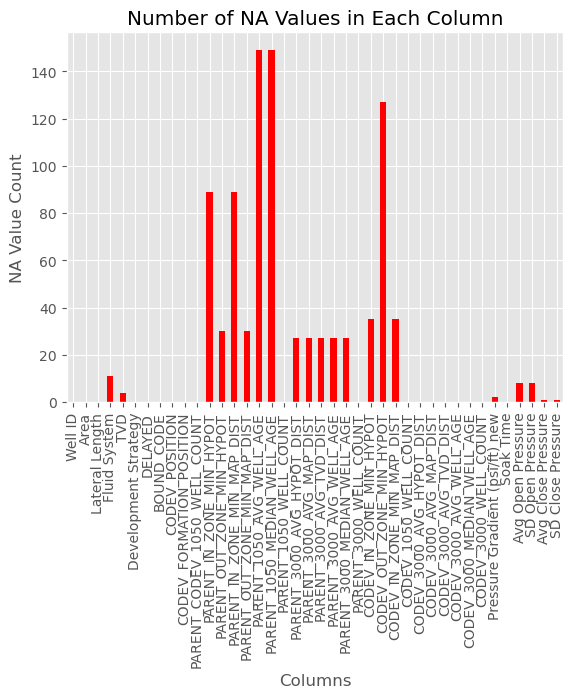


Total number of entries with missing values:  289
Theres a total of 5 categorical columns.

Categorical Columns:
Index(['Area', 'Fluid System', 'Development Strategy', 'CODEV_POSITION',
       'CODEV_FORMATION_POSITION'],
      dtype='object')

Unique Values of Each Categorical Columns:
Area :  ['Acadia' 'Arches' 'Badlands' 'Big Bend' 'Canyonlands' 'Carlsbad Caverns'
 'Crater Lake' 'Denali' 'Dry Tortugas' 'Everglades' 'Glacier'
 'Grand Canyon' 'Grand Teton' 'Great Basin' 'Great Sand Dunes'
 'Great Smoky Mountains' 'Guadalupe Mountains' 'Hot Springs' 'Joshua Tree'
 'Kings Canyon' 'Mammoth Cave' 'Lake Clark' 'Mount Rainier'
 'North Cascades' 'Olympic' 'Petrified Forest' 'Redwood' 'Rocky Mountain'
 'Sequoia' 'Yellowstone' 'Yosemite']
Fluid System :  ['Campbell' 'Young' 'Williams' nan]
Development Strategy :  ['Coke' 'Orange Crush' 'Mountain Dew' 'Sprite' 'Dr Pepper' 'Pepsi'
 'Pibb Extra']
CODEV_POSITION :  ['Edge' 'Middle']
CODEV_FORMATION_POSITION :  ['Edge' 'Middle']


In [73]:
# take off Avg Pump Difference since it is our target variable
new_pump_df = copy_pump_df.drop(['Avg Pump Difference'], axis=1)

# print the columns where there are missing values
print('Total number of attributes with missing values: ', len(pump_df.columns[pump_df.isnull().any()]) )

missing_values = new_pump_df.isnull()

# count the number of missing values per column
num_missing_per_column = missing_values.sum()

# filter and display the columns with missing values and the total number of missing valuesmn
na_counts = new_pump_df.isna().sum()
na_counts.plot(kind='bar', color='red')
plt.title('Number of NA Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('NA Value Count')
plt.show()
# missing_columns = num_missing_per_column[num_missing_per_column > 0]
# print('\nColumns with Missing Values:')
# print('---------------------------------------')
# print(missing_columns.sort_values(ascending=False).nlargest(5))

# lets check how many row/entries have missing values
print('\nTotal number of entries with missing values: ', len(new_pump_df[new_pump_df.isnull().any(axis=1)]) )

# lets check which columns are categorical (we might need to one hot encode them)
print('Theres a total of', len(new_pump_df.select_dtypes(include=['object']).columns), 'categorical columns.\n')
print('Categorical Columns:')
print(new_pump_df.select_dtypes(include=['object']).columns)

# Print the unique values of each categorical column
print('\nUnique Values of Each Categorical Columns:')
for column in new_pump_df.select_dtypes(include=['object']).columns:    
    print(column, ': ', new_pump_df[column].unique())

#### Data Correlation Analysis
The following cell box depicts strong correlations between all features and the strongest features with our target variable.

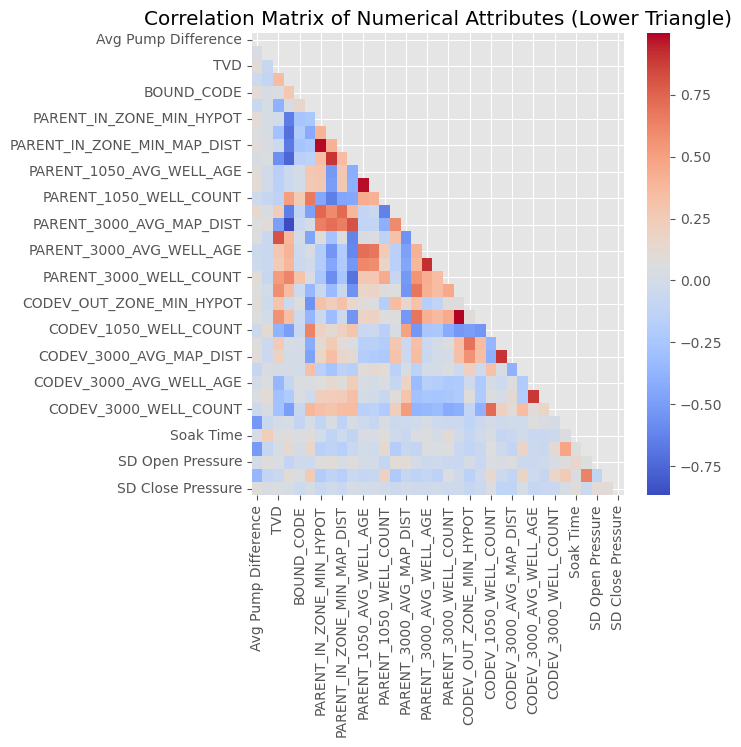

Top 5 Strongestn Positive Correlations with Avg Pump Difference:
0    0.134717
1    0.108694
2    0.106480
3    0.105881
4    0.097064
dtype: float64

Top 5 Strongest Negative Correlations with Avg Pump Difference:
0   -0.531790
1   -0.511519
2   -0.356727
3   -0.085991
4   -0.060235
dtype: float64


In [74]:
# reset copy_pump_df
copy_pump_df = pump_df.copy()

# lets make a correlation matrix visualization WITHOUT the categorical columns and the 'Well ID'
copy_pump_df = copy_pump_df.drop(columns=['Well ID'], axis=1)

# first lets standardize the numerical features
scaler = StandardScaler()
numerical_columns = list(copy_pump_df.select_dtypes(include=['int64', 'float64']).columns)
copy_pump_df[numerical_columns] = scaler.fit_transform(copy_pump_df[numerical_columns])
categorical_columns = list(copy_pump_df.select_dtypes(include=['object']).columns)
numerical_pump_df = copy_pump_df.drop(categorical_columns, axis=1)

# correlation matrix visualization
num_corr_matrix = numerical_pump_df.corr(method='pearson')
upper_mask = np.triu(np.ones_like(num_corr_matrix, dtype=bool))
plt.figure(figsize=(6,6))
sns.heatmap(num_corr_matrix, mask=upper_mask, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Attributes (Lower Triangle)')
plt.show()

# show the 5 strongest correlation values of the numerical attributes with the target variable
# we also wanna take into consideration the negative correlations due to inverse relationships with our target variable
print('Top 5 Strongestn Positive Correlations with Avg Pump Difference:')
top_pos_corr_mixed = list(num_corr_matrix['Avg Pump Difference'].sort_values(ascending=False, key=abs).nlargest(6))
top_pos_corr_mixed.pop(0)
top_pos_corr_mixed = pd.Series(top_pos_corr_mixed)
print(top_pos_corr_mixed)

print('\nTop 5 Strongest Negative Correlations with Avg Pump Difference:')
top_neg_corr_mixed = list(num_corr_matrix['Avg Pump Difference'].sort_values(ascending=True, key=abs).nsmallest(5))
top_neg_corr_mixed = pd.Series(top_neg_corr_mixed)
print(top_neg_corr_mixed)



### Data Cleaning - Data Scaling & kNN Imputation
The following functions help us scale our data and impute our missing values in test data using kNN imputation. We decided to use kNN imputation for this project because it leverages the proximity of data points to estimate missing values, providing a robust approach for handling incomplete datasets.

In [75]:
# HELPER FUNCTION: plot the distribution of a numerical attribute
def x_scale(data):
    return pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

# HELPER FUNCTION: impute missing values in test data using knn imputation
def knn_imputer(X_train, X_test, chosen_features):
    imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=chosen_features)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=chosen_features)


### Feature Selection
We found the following chosen features to be used for our prediction model by using variable ranking and domain knowledge.

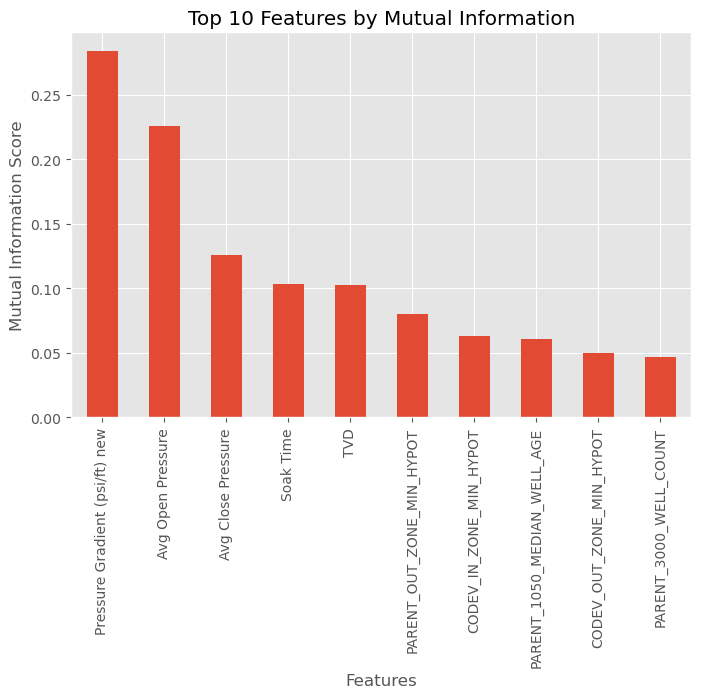

In [76]:
# these are the features that we choosing from for our models, we plan on removing some of these features
predicted_features_domain_knowledge = ['Lateral Length', 'TVD', 'DELAYED', 'PARENT_CODEV_1050_WELL_COUNT',
    'PARENT_IN_ZONE_MIN_HYPOT', 'PARENT_OUT_ZONE_MIN_HYPOT',
    'PARENT_1050_MEDIAN_WELL_AGE', 'PARENT_1050_WELL_COUNT',
    'PARENT_3000_AVG_HYPOT_DIST', 'PARENT_3000_AVG_TVD_DIST',
    'PARENT_3000_MEDIAN_WELL_AGE', 'PARENT_3000_WELL_COUNT',
    'CODEV_IN_ZONE_MIN_HYPOT', 'CODEV_OUT_ZONE_MIN_HYPOT',
    'CODEV_1050_WELL_COUNT', 'CODEV_3000_AVG_HYPOT_DIST',
    'CODEV_3000_AVG_TVD_DIST', 'CODEV_3000_MEDIAN_WELL_AGE',
    'CODEV_3000_WELL_COUNT', 'Pressure Gradient (psi/ft) new', 'Soak Time',
    'Avg Open Pressure', 'Avg Close Pressure']


# drop all the features that are not in the predicted_features_domain_knowledge list
df_predictions_knowledge = copy_pump_df[predicted_features_domain_knowledge][~pump_df['Avg Pump Difference'].isna()]
target_df = pump_df[~pump_df['Avg Pump Difference'].isna()]
target_data = target_df[TARGET].values

X = df_predictions_knowledge
y = target_data

# lets check the correlation matrix of the features we chose
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# handle missing values in X
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df_predictions_knowledge)

# Identifying discrete features if applicable
# discrete = [True/False] based on whether the feature is discrete or continuous
# For example, discrete could be a list like [True, False, False, True,...] corresponding to each feature in X
discrete = [False] * len(X.columns)  # Modify this as per your dataset

# Running the mutual information regression and storing the results in a pandas series
mi = mutual_info_regression(X_imputed, y, discrete_features=discrete)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Show the top 10 most important features
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
mi_series.head(10).plot(kind='bar')
plt.title('Top 10 Features by Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.show()